# Importing Quantum Computing Libraries

In [1]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms import QSVC
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel


In [2]:
from qiskit_ibm_runtime import Session
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Sampler as SamplerQ

service = QiskitRuntimeService(channel='ibm_quantum', token='f73393d0b4e099ab95417406a2c31844acdfaaf9373a2e0a3366ea247a6fb275652ea4d3fcb4ba2de1318577d3bced2d09aeb9610f761eaddb0a983d6b033661')
backend=service.least_busy()

## Loading Dataset using pandas library

In [3]:
import pandas as pd
df=pd.read_csv('african_crises.csv')

## Label Encoding
### What is Label Encoding?
Label encoding converts categorical values into numerical values, allowing machine learning models to process them.


In [4]:
from sklearn.preprocessing import LabelEncoder
# Create a LabelEncoder object
le = LabelEncoder()

# Apply label encoding to categorical columns
for col in df.select_dtypes(include=['object']).columns:
  df[col] = le.fit_transform(df[col])

# Display the updated DataFrame
df.head(5)

,case,cc3,country,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis
0,1,3,0,1870,1,0.052264,0,0,0.0,3.441456,0,0,0,0
1,1,3,0,1871,0,0.052798,0,0,0.0,14.149140,0,0,0,1
2,1,3,0,1872,0,0.052274,0,0,0.0,-3.718593,0,0,0,1
3,1,3,0,1873,0,0.051680,0,0,0.0,11.203897,0,0,0,1
4,1,3,0,1874,0,0.051308,0,0,0.0,-3.848561,0,0,0,1


# Scaling The Dataset

In [5]:
from sklearn.preprocessing import StandardScaler
# Create a Standard Scalar object
scalar = StandardScaler()

# Apply scaling to numerical columns
df[['exch_usd', 'inflation_annual_cpi']] = scalar.fit_transform(df[['exch_usd', 'inflation_annual_cpi']])

# Display the updated DataFrame
df.head(5)

,case,cc3,country,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis
0,1,3,0,1870,1,-0.386713,0,0,0.0,-0.030863,0,0,0,0
1,1,3,0,1871,0,-0.386708,0,0,0.0,-0.030848,0,0,0,1
2,1,3,0,1872,0,-0.386712,0,0,0.0,-0.030874,0,0,0,1
3,1,3,0,1873,0,-0.386718,0,0,0.0,-0.030852,0,0,0,1
4,1,3,0,1874,0,-0.386721,0,0,0.0,-0.030874,0,0,0,1


# Data Preparation For Quantum Processing

In [6]:
dfq=df.copy()

# Feature Reduction

# 1. Correlation Method

In [7]:
corr_matrix = dfq.corr()


# Calculate correlation with target


In [8]:
# Calculate correlation matrix
correlation_matrix = dfq.corr()

# Get correlations with target variable 'banking_crisis'
target_correlations = correlation_matrix['banking_crisis'].abs()

# Filter columns with correlation < 0.5
columns_to_drop = target_correlations[target_correlations < 0.2].index
columns_to_drop = columns_to_drop[columns_to_drop != 'banking_crisis']  # exclude target variable

# Drop columns
dfq_filtered_corr = dfq.drop(columns=columns_to_drop)

print(f"Dropped columns: {list(columns_to_drop)}")
print(f"Remaining columns: {dfq_filtered_corr.columns}")

print(f"Number of remaining columns: {len(dfq_filtered_corr.columns)}")

Dropped columns: ['case', 'cc3', 'country', 'exch_usd', 'gdp_weighted_default', 'inflation_annual_cpi', 'independence', 'currency_crises']
Remaining columns: Index(['year', 'systemic_crisis', 'domestic_debt_in_default',
       'sovereign_external_debt_default', 'inflation_crises',
       'banking_crisis'],
      dtype='object')
Number of remaining columns: 6


In [9]:
dfq_filtered_corr

,year,systemic_crisis,domestic_debt_in_default,sovereign_external_debt_default,inflation_crises,banking_crisis
0,1870,1,0,0,0,0
1,1871,0,0,0,0,1
2,1872,0,0,0,0,1
3,1873,0,0,0,0,1
4,1874,0,0,0,0,1
...,...,...,...,...,...,...
1054,2009,1,1,1,0,0
1055,2010,0,1,1,0,1
1056,2011,0,1,1,0,1
1057,2012,0,1,1,0,1


# 2.**Principal Component Analysis (PCA)**: 
### Select top k principal components explaining most of the variance.


In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)  # retain 95% of variance
dfq_filtered_pca = pca.fit_transform(dfq.drop(['banking_crisis'], axis=1))

In [11]:
dfq_filtered_pca

array([[-102.27841355,  -18.41620694,    1.01305105],
       [-101.29399201,  -18.58228248,    1.05353039],
       [-100.30802895,  -18.74875589,    1.06432099],
       ...,
       [  48.54020328,   27.66462765,   -1.47455007],
       [  49.5261664 ,   27.49815422,   -1.46375981],
       [  50.51212951,   27.33168079,   -1.4529697 ]])

In [12]:
dfq_filtered_pca.size

3177

In [13]:
# Convert array to DataFrame
dfq_filtered_pca = pd.DataFrame(dfq_filtered_pca)

In [14]:
# Add 'banking_crisis' column
dfq_filtered_pca['banking_crisis'] = dfq['banking_crisis']


# Reducing Samples

# Sample Reduction of Correlation Based Data Set

In [15]:
from sklearn.utils import resample

# Define sample size
sample_size = 100

# Stratified sampling (maintaining class balance)
dfq_sampled_corr = pd.concat([resample(dfq_filtered_corr[dfq_filtered_corr['banking_crisis'] == c], replace=False, n_samples=int(sample_size * len(dfq_filtered_corr[dfq_filtered_corr['banking_crisis'] == c]) / len(dfq_filtered_corr))) for c in dfq_filtered_corr['banking_crisis'].unique()])

In [16]:
dfq_sampled_corr

,year,systemic_crisis,domestic_debt_in_default,sovereign_external_debt_default,inflation_crises,banking_crisis
875,1993,1,0,0,0,0
204,1999,1,0,1,0,0
194,1989,1,0,1,0,0
406,1983,1,0,0,0,0
140,1993,0,1,1,1,0
...,...,...,...,...,...,...
355,1932,0,0,0,0,1
176,1971,0,0,0,1,1
155,2008,0,0,0,0,1
605,1972,0,0,0,0,1


# Sample Reduction of PCA Based Data Set

In [17]:

# Define sample size
sample_size = 100

# Stratified sampling (maintaining class balance)
dfq_sampled_pca = pd.concat([resample(dfq_filtered_pca[dfq_filtered_pca['banking_crisis'] == c], replace=False, n_samples=int(sample_size * len(dfq_filtered_pca[dfq_filtered_pca['banking_crisis'] == c]) / len(dfq_filtered_pca))) for c in dfq_filtered_pca['banking_crisis'].unique()])

In [18]:
dfq_sampled_pca

,0,1,2,banking_crisis
1041,33.729904,30.202446,0.649628,0
259,19.426793,-24.649733,-1.962072,0
185,7.685112,-28.078819,-1.661228,0
62,18.019092,-38.731525,2.124289,0
184,6.697725,-27.909632,-1.522019,0
...,...,...,...,...
80,35.764139,-41.731569,2.114636,1
503,44.452350,-8.436977,-0.328618,1
1001,-5.717160,36.862316,0.205409,1
132,1.388929,-35.224681,-0.129888,1


# Splitting of Data Sets into Test and Train Samples

In [19]:
from sklearn.model_selection import train_test_split
# Training and Testing for Corr Based Data
X=dfq_sampled_corr.drop('banking_crisis',axis=1)
y=dfq_sampled_corr['banking_crisis']
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y, test_size=0.20, random_state=40)

# Training and Testing of PCA based Data
X_pca=dfq_sampled_pca.drop('banking_crisis',axis=1)
y_pca=dfq_sampled_pca['banking_crisis']
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_pca, y_pca, test_size=0.20, random_state=40)

# Feature Maps

# Featue Map For Corr Based Data

In [20]:
feature_dim = X_train_c.shape[1]

feature_map_c = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement="linear")

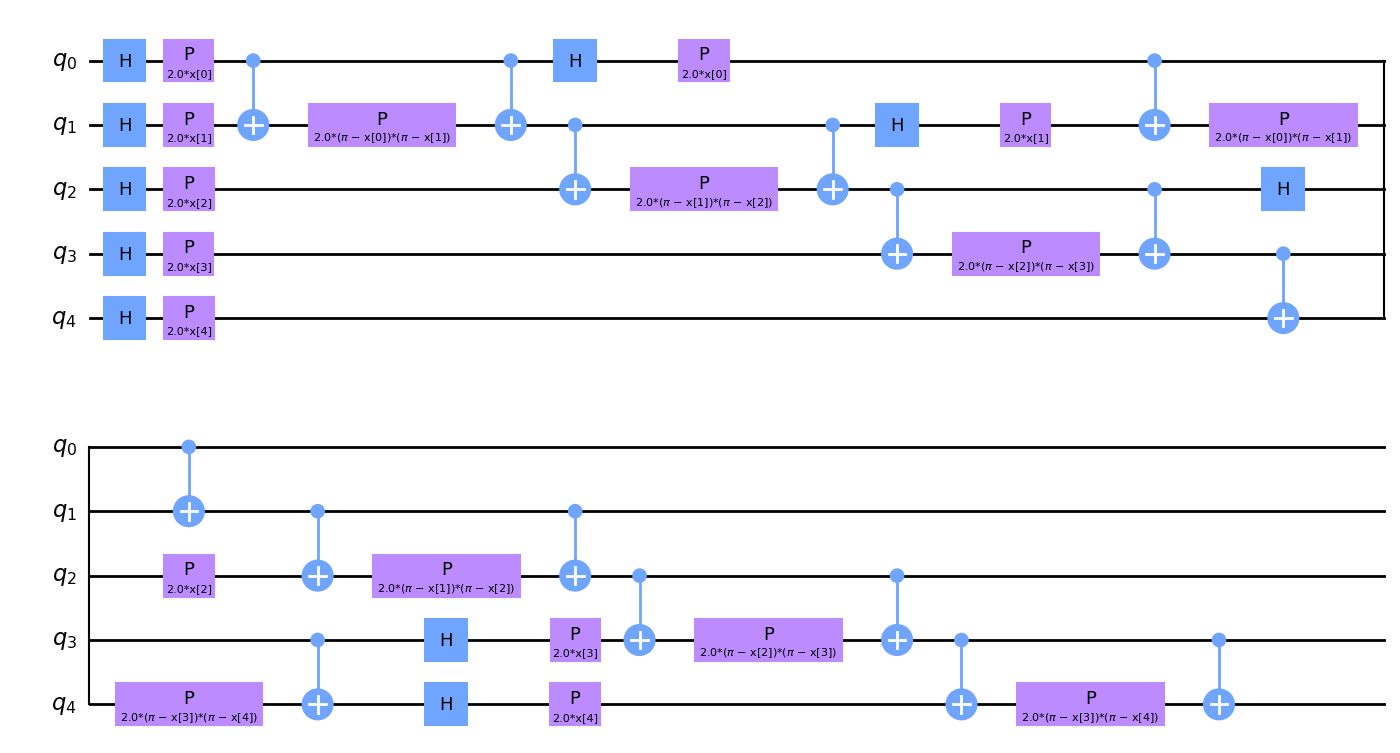

In [21]:
feature_map_c.decompose().draw(output="mpl", style="clifford", fold=20)

# Featue Map For PCA Based Data

In [22]:
feature_dim = X_train_p.shape[1]

feature_map_p = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement="linear")

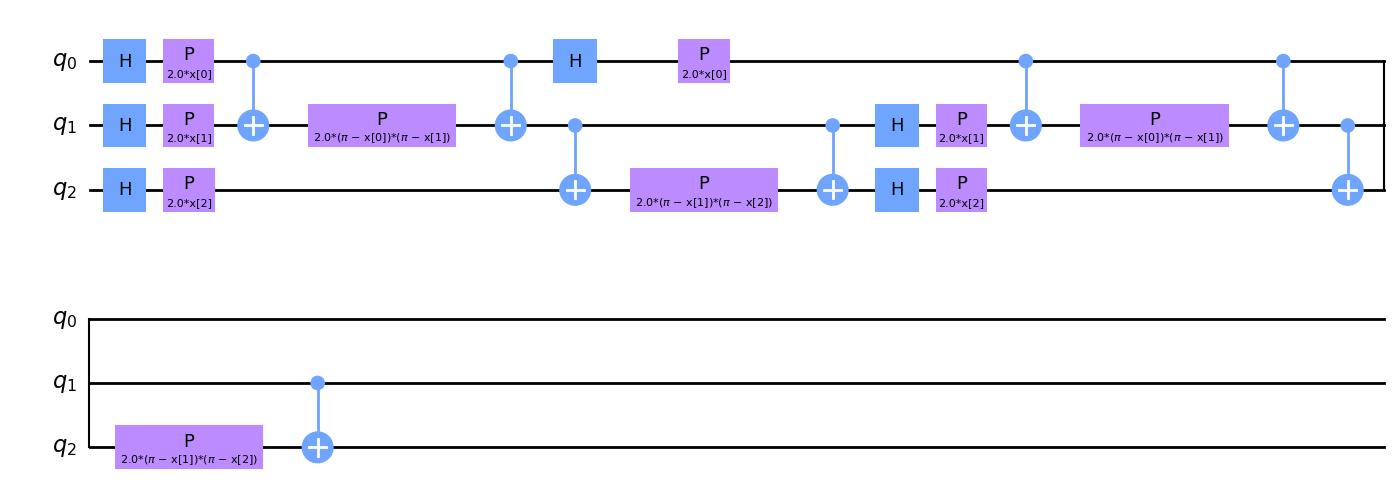

In [23]:
feature_map_p.decompose().draw(output="mpl", style="clifford", fold=20)

# Traspiling Feature Map

In [31]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)

In [32]:
feature_map_c_tr = pass_manager.run(feature_map_c)
feature_map_p_tr = pass_manager.run(feature_map_p)

In [40]:
feature_map_p_tr.decompose().draw(output="mpl", style="clifford", fold=20)

# Setting Up Quantum Kernel

In [41]:

sampler=SamplerQ(mode=backend)

# Quantum Kernel (Correlation Based Data)

In [42]:
fidelity = ComputeUncompute(sampler=sampler)
q_kernel_corr = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map_c_tr)

# Quantum Kernel (PCA Based Data)

In [46]:
q_kernel_pca = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map_p_tr)

# QSVC on Corr Based and PCA Based Kernel

In [50]:
import time
qsvc = QSVC(
    quantum_kernel=q_kernel_pca
)

In [52]:
start = time.time()
qsvc.fit(X_train_p, y_train_p)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

qsvc_score = qsvc.score(X_test_p, y_test_p)

print(f"QSVC classification test score: {qsvc_score}")

CircuitError: "name conflict adding parameter 'x[1]'"

In [48]:
# Evaluate training matrix
matrix_train = q_kernel_pca.evaluate(X_train_p)

# Evaluate testing matrix
matrix_test = q_kernel_pca.evaluate(X_test_p, X_train_p)

CircuitError: "name conflict adding parameter 'x[1]'"

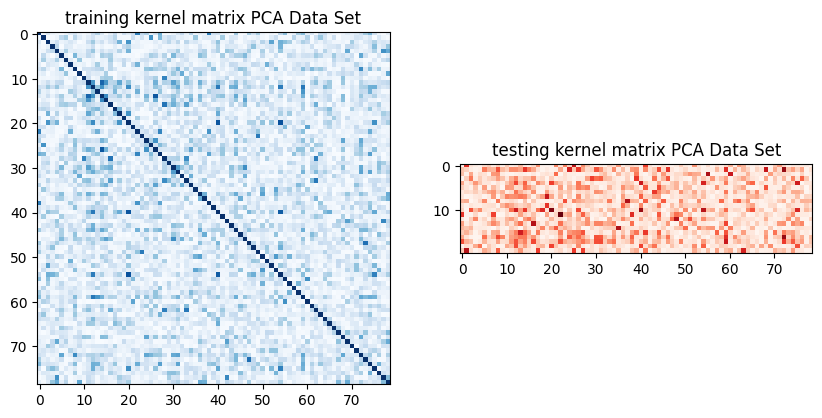

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("training kernel matrix PCA Data Set")

axs[1].imshow(np.asmatrix(matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("testing kernel matrix PCA Data Set")

plt.show()

# Running on Quantum Runtime

#IBM Runtime Setup

# Feature Maps for Quantum Processing

In [36]:
sampler=SamplerQ(mode=backend)

In [37]:
from qiskit_algorithms.state_fidelities import ComputeUncompute_Q
fidelity = ComputeUncompute_Q(sampler=sampler)
q_kernel_corr = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map_c)

ImportError: cannot import name 'ComputeUncompute_Q' from 'qiskit_algorithms.state_fidelities' (c:\Users\SURFACE\Downloads\Classical Implementation (PCA _ SVM)\2. African Economic Crises prediction\myenv\Lib\site-packages\qiskit_algorithms\state_fidelities\__init__.py)

In [ ]:
session = Session(backend=backend)

qsvc = QSVC(quantum_kernel=optimized_kernel, backend=backend)

start = time.time()
# Fit QSVC
qsvc.fit(X_train, y_train)

# Predict labels
labels_test = qsvc.predict(X_test)

# Evaluate test accuracy
accuracy_test = metrics.balanced_accuracy_score(y_true=y_test, y_pred=labels_test)
print(f"Accuracy test: {accuracy_test}")
elapsed = time.time() - start